# ECSE 526 - A1 - Dynamic Connect 4 Implementation

The following notebook is a walk through of the implementation of DynamicConnect4 (described on the [course website](http://cim.mcgill.ca/~jer/courses/ai/assignments/as1.html)). These functions were then copied to .py files to build the final game playing agent.

This project requires the following packages be installed : 

`scipy, telnetlib, numpy, hashlib, argparse`

__Quick Note__ :

I've documented and explained most portions of this implementation (important details in both text cells and code comments). Keep in mind this was the rough-document which includes some brain storming / adhoc testing (its not as concise as the report).

## Implementation Overview

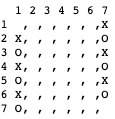

__Context :__

For this project I tried to codify most of the gameState and interactions as matrix operations in hopes to optimize performance. Knowing that many numpy functions are implemented in c, I aimed to minimize the use of python-for loops in favour of vectorized operations in numpy.

__Code Organization :__ 

This notebook is sectioned sequentially, documenting not only the code but the thought process and testing throughout implementation. At a high-level the implementation is structures as follows : 
- Game Basics
    - Parsing game state, generating actions, simple heuristic, A-Star algo
- Game Agent
    - Define Minimax & AlphaBeta, run test game
- Connect to Server
- Play game against server

# Game Basics

## Implementation Notes : 

__Game Board State__ : The board is represented as a 7x7 matrix. Empty cells = 0


__Pieces__ : Players are assigned a number (as defined by PLAYER_IDS). Each piece is either -1 or 1, these corespond to player number (ie player1 uses pieces 1). These pieces are placed in the matrix

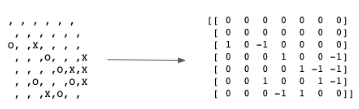

__Generating Actions__ : Since the pieces and game board is a matrix, moving pieces can be done by subtracting the piece from its current position and adding it to the next.

__Successor States__ : Successor states are calculated simply by adding the 7x7 move matrices generated.

__Validating Board State__ : Validating board states can be done by counting the number of pieces for each player. This is used to eliminate invalid moves.

__Heuristic__ : Keeping with the theme of matrix operations.. Counting the number of connected pieces for either player can be done with a matrix operation. More details in the section

## Converting String->State->String

In [1]:
import numpy as np
import time
import re

In [2]:
PLAYER_IDS = {
    'color':['white','black'],
    'symbol':['O','X'],
    'num':[1,-1]
}

In [3]:
## Take string representation of state and return 2d matrix
def strToState(strState):
    arrState = re.sub('^ *\n|\n *$','', strState).replace('\n',',').replace(' ','').split(',')
    arrState = np.array(arrState).reshape((7,7))
    
    a = np.where(arrState=='X', -1, arrState)
    a = np.where(a=='O', 1, a)
    matState = np.where(a=='', 0, a).astype(int)
    
    return np.matrix(matState)

## 2d matrix representation of state --> string representation.. (reverse operation of above)
def stateToStr(state):
    return ' '+re.sub('\[|\]','', re.sub(' *(-?\d)', '\g<1>,',str(state.astype(int))).replace(',]',']')).replace('-1','X').replace('1','O').replace('0',' ')


In [4]:
## Define some sample starting states for testing implementation
str1 = """
, , , , , , 
 , , , , , , 
O, ,X, , , , 
 , , ,O, , ,X
 , , , ,O,X,X
 , ,O, , ,O,X
 , , ,X,O, , 
"""

str2 = """O,O, , , , , 
X, , , , , , 
 , ,X, , ,O, 
 , ,X,O, , ,X
 , , , ,O,X,
 ,X, , , , , 
O, , , , , ,
"""

### Test Converting Str and States

In [5]:
import pandas as pd

In [6]:
print(str1)
testState = strToState(str1)
print(testState)
print()
print(stateToStr(testState))


, , , , , , 
 , , , , , , 
O, ,X, , , , 
 , , ,O, , ,X
 , , , ,O,X,X
 , ,O, , ,O,X
 , , ,X,O, , 

[[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 1  0 -1  0  0  0  0]
 [ 0  0  0  1  0  0 -1]
 [ 0  0  0  0  1 -1 -1]
 [ 0  0  1  0  0  1 -1]
 [ 0  0  0 -1  1  0  0]]

  , , , , , , 
  , , , , , , 
 O, ,X, , , , 
  , , ,O, , ,X
  , , , ,O,X,X
  , ,O, , ,O,X
  , , ,X,O, , 


## Generating Actions & Successors

In [7]:
# https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.ndimage.filters.convolve.html
from scipy import ndimage

In [8]:
## Given (gameStateMatrix, CoordinatesForPiece)
## Builds and returns array of 4 'move-matrices' for piece at given coords
## This method won't generate moves off the board. 
def generateMovesForPiece(state, coords):
    intPiece = state[coords]
    matAction = np.zeros((7,7))
    matAction[coords] = -1*intPiece
    actions = []
    
    
    if coords[0]+1<7:
        a1 = matAction.copy()
        a1[coords[0]+1, coords[1]] = intPiece
        actions.append(a1)
    if coords[0]-1>=0:
        a2 = matAction.copy()
        a2[coords[0]-1, coords[1]] = intPiece
        actions.append(a2)
    if coords[1]+1<7:
        a3 = matAction.copy()
        a3[coords[0], coords[1]+1] = intPiece
        actions.append(a3)
    if coords[1]-1>=0:
        a4 = matAction.copy()
        a4[coords[0], coords[1]-1] = intPiece
        actions.append(a4)
    
    return np.array(actions)

def isValidState(state):
    if state.sum() != 0 : return False
    if np.count_nonzero(state) != 12 : return False
    return True

### Test Generating Moves and Successor State

In [9]:
newState =  testState + generateMovesForPiece(testState, (0,2))[0]
print(stateToStr(testState))
print(stateToStr(newState))

  , , , , , , 
  , , , , , , 
 O, ,X, , , , 
  , , ,O, , ,X
  , , , ,O,X,X
  , ,O, , ,O,X
  , , ,X,O, , 
  , , , , , , 
  , , , , , , 
 O, ,X, , , , 
  , , ,O, , ,X
  , , , ,O,X,X
  , ,O, , ,O,X
  , , ,X,O, , 


### Generate Successors for Player
Abstract above methods further to easily generate all potential valid moves for a given player..

In [10]:
## Iterate pieces for player and generate all moves
def generateMovesForPlayer(player, state):
    piecesCoords = list(zip(*np.where(state==player)))
    moves = np.concatenate(list(map(lambda c:generateMovesForPiece(state,c), piecesCoords)))
    return moves

## Check which moves matrices lead to valid game states.
## Return list of only valid moves
def validateMoves(state, moves):
    nextStates = np.add(moves, np.asarray(state))
    counts = np.sum(np.count_nonzero(nextStates,axis=1), axis=1)
    m_counts = counts==12
    return moves[m_counts]

## Generate all moves, validate them, calculate the successor states for player
def generateSuccessorsForPlayer(player, state):
    moves = generateMovesForPlayer(player, state)
    validMoves = validateMoves(state, moves)
    return np.add(validMoves, np.asarray(state))

## Heuristic

Using the following 4 kernels (aka filters) we can apply convolution operation against the 7x7 game state matrix. This will return a 'filtered' matrix who's cell values correspond to the number of pieces of overlap with each kernel configuration.

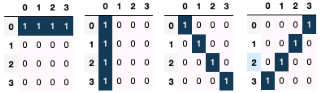

Once the convolution is calculated, the max value of the result is the player's score (ie number of connected pieces). When this max number is 4, that player wins!

### Basic Heuristic

In [11]:
## Define filter matrices
filtDiag4 = np.diag((1,1,1,1))
filtDiagx4 = np.flip(filtDiag4, axis=0)
filtFlat4 = [[1,1,1,1]]
filtVert4 = [[1],
             [1],
             [1],
             [1]]

## Run convolutions against state and return max score
def scoreMaxConnected(player, state):
    pieces = (state==player).astype(int)
    flatCount = ndimage.convolve(pieces, filtFlat4, mode='constant', cval=0.0).max()
    vertCount = ndimage.convolve(pieces, filtVert4, mode='constant', cval=0.0).max()
    diagCount = ndimage.convolve(pieces, filtDiag4, mode='constant', cval=0.0).max()
    diagxCount = ndimage.convolve(pieces, filtDiagx4, mode='constant', cval=0.0).max()
    return np.max((flatCount, vertCount, diagCount, diagxCount))

In [12]:
scoreMaxConnected(1, testState)

3

### Fuzzy Heuristic

In [13]:
fuzzyFiltDiag4 = np.array([
    [1,1,0,0,0,0],
    [1,2,1,0,0,0],
    [0,1,2,1,0,0],
    [0,0,1,2,1,0],
    [0,0,0,1,2,1],
    [0,0,0,0,1,1]
])
fuzzyFiltDiagx4 = np.flip(fuzzyFiltDiag4, axis=0)
fuzzyFiltFlat4 = np.array([[0,1,1,1,1,0], [1,2,2,2,2,1], [0,1,1,1,1,0]])
fuzzyFiltVert4 = fuzzyFiltFlat4.T

def scoreMaxConnectedFuzzy(player, state):

    flatCount = ndimage.convolve(state, fuzzyFiltFlat4, mode='constant', cval=0.0)
    vertCount = ndimage.convolve(state, fuzzyFiltVert4, mode='constant', cval=0.0)
    diagCount = ndimage.convolve(state, fuzzyFiltDiag4, mode='constant', cval=0.0)
    diagxCount = ndimage.convolve(state, fuzzyFiltDiagx4, mode='constant', cval=0.0)
    fuzzyScores = np.array([flatCount, vertCount, diagCount, diagxCount])
    return np.max(fuzzyScores) if player == 1 else np.min(fuzzyScores)

def fuzzyHeuristic(player, state):
    return scoreMaxConnected(player, state) + scoreMaxConnectedFuzzy(player, state)/8

## Sanity Check with Search Algo

__Validating Proof-of-Concept__ :

Now that the game state, successor states, and heuristic have all been defined we can setup a quick search problem. 

Can a graph search find the fastest route to the goal state?

In [14]:
from simpleai.search import SearchProblem, astar, breadth_first
from hashlib import sha1

## Simple caching mechanism
DB_STATE = {}
def put(state):
    strHash = sha1(state.tobytes()).hexdigest()
    DB_STATE[strHash] = state
    return strHash

def get(strHash):
    return DB_STATE[strHash]

## Simple search problem wrapper
class DynamicConnect4(SearchProblem):
    def actions(self, state):
        return generateMovesForPlayer(1, get(state))
    def result(self, state, action):
        return put(get(state) + action)
    def is_goal(self, state):
        return scoreMaxConnected(1, get(state))==4
    def heuristic(self, state):
        score = scoreMaxConnected(1, get(state))
        print(state)
        return score

In [15]:
str3 = """
, , , , , , 
 , , , , , , 
O, ,X, , , , 
 , , ,O, , ,X
 , , , ,O,X,X
 , ,O, , ,O,X
 , , ,X,O, , 
 """
strToState(str3)

matrix([[ 0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0],
        [ 1,  0, -1,  0,  0,  0,  0],
        [ 0,  0,  0,  1,  0,  0, -1],
        [ 0,  0,  0,  0,  1, -1, -1],
        [ 0,  0,  1,  0,  0,  1, -1],
        [ 0,  0,  0, -1,  1,  0,  0]])

In [16]:
problem = DynamicConnect4(initial_state=put(strToState(str3)))
result = breadth_first(problem)

In [17]:
for i in result.path():
    print('-------',i[1],'--------')
    print(stateToStr(get(i[1])))

------- 37b1b09d1cfde25e10e35dabc809c733697f4223 --------
  , , , , , , 
  , , , , , , 
 O, ,X, , , , 
  , , ,O, , ,X
  , , , ,O,X,X
  , ,O, , ,O,X
  , , ,X,O, , 
------- 12bbf58d46b8e43134504d8944045cac66978083 --------
  , , , , , , 
  , , , , , , 
 O, ,X, , , , 
  , , , ,O, ,X
  , , , ,O,X,X
  , ,O, , ,O,X
  , , ,X,O, , 
------- e6db91eb458d1515943fc7a4b219ed309e2f811e --------
  , , , , , , 
  , , , , , , 
 O, ,X, , , , 
  , , , ,O, ,X
  , , , ,O,X,X
  , ,O, ,O, ,X
  , , ,X,O, , 


# Game Agent

## MiniMax

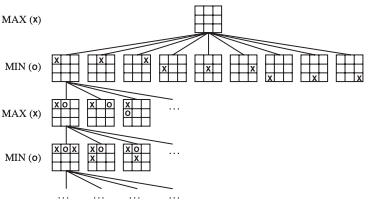

Implementation of minimax was inspired by pseudo-code implementations in both the text book (Artificial Intelligence : A Modern Approach) and [wikipedia](https://en.wikipedia.org/wiki/Minimax)


In [18]:
## Transposition table
DB_TRANSP = {}

## Takes : (stateHash, playerNum, searchDepth)
## Returns : (bestScore, bestSuccessorStateMatrix)
def minimax(stateStr, player, depth):
    if hasattr(minimax, 'count') : minimax.count = minimax.count+1
    if (depth,stateStr) in DB_TRANSP: return DB_TRANSP[(depth,stateStr)]
    state = get(stateStr)
    score = scoreMaxConnected(player*-1, state)*player*-1
    if depth==0 or abs(score)==4:
        return (score, state)
    
    actionValues = []
    arrSuccessors = generateSuccessorsForPlayer(player, state)
    for st in arrSuccessors:
        v, _ = minimax(put(st), player*-1, depth-1)
        actionValues.append(v)
#     print('actionValues', len(actionValues), actionValues)
    bestScore = max(actionValues) if (player > 0) else min(actionValues)
    DB_TRANSP[(depth,stateStr)] = (bestScore, arrSuccessors[actionValues.index(bestScore)])
    return DB_TRANSP[(depth,stateStr)]


### Test MiniMax with Synthetic Problem

In [19]:
str4 = """
X,X,X, , ,X, 
 , , ,O, , , 
 , , , ,X, , 
 , , ,O, , , 
 , , ,O, , , 
O, , ,O, , , 
O, , , , ,X, 
 """

In [20]:
DB_STATE = {}
DB_TRANSP = {}
minimax(put(strToState(str4)), -1, 2)

(3, array([[-1., -1., -1.,  0.,  0., -1.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  0., -1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  1.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0., -1.,  0.]]))

## AlphaBeta

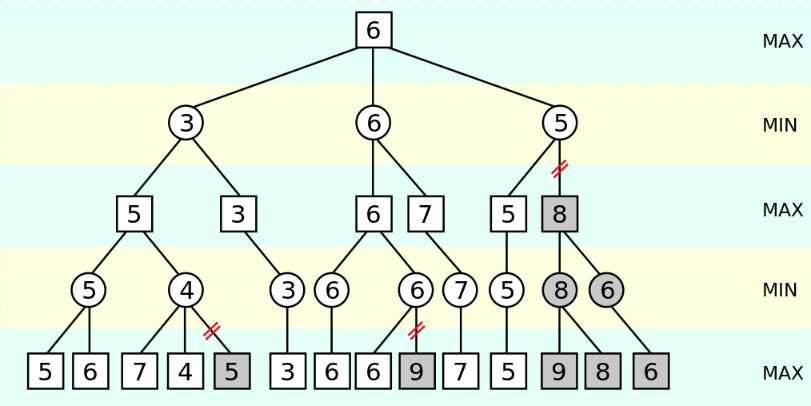

Implementation of AlphaBeta pruning was also inspired by pseudo-code implementations in both the text book (Artificial Intelligence : A Modern Approach) and [wikipedia](https://en.wikipedia.org/wiki/Alpha–beta_pruning)


In [21]:
def alphaBeta(stateStr, player, depth, alpha=-np.inf, beta=np.inf):
    if hasattr(alphaBeta, 'count') : alphaBeta.count = alphaBeta.count+1
    if (depth, stateStr) in DB_TRANSP: return DB_TRANSP[(depth, stateStr)]
    state = get(stateStr)
    score = scoreMaxConnected(player*-1, state)*player*-1
    if depth==0 or abs(score)==4:
        return (score, state)
    
    actionValues = []
    arrSuccessors = generateSuccessorsForPlayer(player, state)
    for st in arrSuccessors:
        v, _ = alphaBeta(put(st), player*-1, depth-1, alpha, beta)
        
        actionValues.append(v)
        if player>0:
            alpha = max(alpha, v)
        else :
            beta = min(beta, v)
        if beta <= alpha:
            break
    
    bestScore = max(actionValues) if (player > 0) else min(actionValues)
    DB_TRANSP[(depth, stateStr)] = (bestScore, arrSuccessors[actionValues.index(bestScore)])
    return DB_TRANSP[(depth, stateStr)]


### Test AlphaBeta with Synthetic Problem

In [22]:
DB_STATE = {}
DB_TRANSP = {}
alphaBeta(put(strToState(str4)), 1, 3)

(4, array([[-1., -1., -1.,  0.,  0., -1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1., -1.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  1.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0., -1.,  0.]]))

# Run Test Game

## Define GamePlay Loop

In [23]:
def minimaxAgent(state, player):
    return minimax(state, player, 4)

def alphaBetaAgent(state, player):
    return alphaBeta(state, player, 4)

In [24]:
def playGame(initStateStr, maxTurns=100, agent=minimaxAgent, verbose=False):
    score = 0
    count = 0
    DB_STATE = {}
    DB_TRANSP = {}
    gameState = put(strToState(initStateStr))
    while abs(score)!=4 and count<maxTurns:
        player = count%2*(-2)+1
        _, gameState = agent(gameState, player)
        score = scoreMaxConnected(player, gameState)
        if verbose : 
            print('------ Turn : ', count,', Player : ', player,' -------')
            print(stateToStr(gameState))
        gameState = put(gameState)
        count += 1

    print('--------- WINNER !! ----------')
    print('------ Turn : ', count,', Player : ', player,' -------')
    print(stateToStr(get(gameState)))

## Play Game (MiniMax)

In [25]:
%%time
DB_STATE = {}
DB_TRANSP = {}
playGame(str1)

--------- WINNER !! ----------
------ Turn :  17 , Player :  1  -------
  , , , , , , 
  , , , , , , 
  , , , , , , 
  , , , , , ,X
  , ,X, , ,X,X
  , ,O,O,O,O,X
 O, , ,X,O, , 
CPU times: user 29.8 s, sys: 198 ms, total: 30 s
Wall time: 30 s


## Play Game (AlphaBeta)

In [26]:
%%time
DB_STATE = {}
DB_TRANSP = {}
playGame(str1, agent=alphaBetaAgent)

--------- WINNER !! ----------
------ Turn :  17 , Player :  1  -------
  , , , , , , 
  , , , , , , 
  , , , , , , 
  , , , , , ,X
  , ,X, , ,X,X
  , ,O,O,O,O,X
 O, , ,X,O, , 
CPU times: user 3 s, sys: 24.3 ms, total: 3.03 s
Wall time: 3.03 s


# Connecting to Game Server

## Establish Connection

In [27]:
import telnetlib

In [28]:
SERVER = {
    'host' : 'localhost',
    'port' : 12345,
    'colour' : 'black',
    'game_id' : 'mytestgame',
}

In [29]:
def connectToServer(serverObj) :
    host = serverObj['host']
    port = serverObj['port']
    colour = serverObj['colour']
    game_id = serverObj['game_id']

    tn = telnetlib.Telnet(host, port)
    tn.write(bytes('{} {}\n'.format(game_id, colour), 'ascii'))
    print('waiting for game :', game_id)
    tn.read_until(bytes(game_id, 'ascii'))
    return tn


In [30]:
def readRemote(tnServer):
    resp = tnServer.read_until(bytes('\n', 'ascii')).decode('ascii')
    print('Reading : ', resp)
    return resp

def getRemoteMove(tnServer, state, player):
    remoteStr = readRemote(tnServer)
    if not re.match('^[1-7]{2}[NSWE]', remoteStr) : 
        print('Cannot parse to move :', remoteStr);
        return None
    
    # validate opponent is moving correct piece
    if state[int(remoteStr[0])-1, int(remoteStr[1])-1] != player:
        print('Attempting to move wrong piece :', remoteStr);
        return None

    newState = state + strToMove(remoteStr, player)
    if not isValidState(newState) :
        print('Invalid State from Server\n', remoteStr)
        return None
    return newState

## Parse Moves from Server

In [31]:
DIR = {
    'N':(-1,0),
    'S':(1,0),
    'E':(0,-1),
    'W':(0,1)
}

moveStr = '57E\n'
player = 1

def strToMove(moveStr, player):
    moveList = tuple(moveStr[:3])
    moveArr = np.zeros((7,7))
    moveArr[int(moveList[0])-1, int(moveList[1])-1] = -1*player
    newPos = np.add(np.array(moveList[:2]).astype(int), np.array(DIR[moveList[2]]))
    moveArr[newPos[0]-1,newPos[1]-1] = player
    return moveArr

def moveToStr(moveArr, player):
    coords = np.array(np.where(moveArr==player)).reshape(-1)
    oldCoords = np.array(np.where(moveArr==-1*player)).reshape(-1)
    movementTup = coords - oldCoords
    direction = list(DIR.keys())[list(DIR.values()).index(tuple(movementTup))]
    return '{}{}{}'.format(oldCoords[0]+1, oldCoords[1]+1, direction)

### Quick Test Move Parsing

In [32]:
moveArr = strToMove('11S\n', player)
moveToStr(moveArr, player)

'11S'

# Play Against Server

## Wrap Game Playing Agent

In [33]:
def getAiMove(state, player, time_limit, tnServer):
    (bestScore, nextState) = alphaBetaAgent(put(state), player)
    moveArr = nextState-state
    moveStr = moveToStr(moveArr, player)
    tnServer.write(bytes(moveStr + '\n', 'ascii'))
    print('Wrote/Response', readRemote(tnServer), '\n')
    return nextState

## Establish GamePlay Loop

In [34]:
def game_ai_vs_remote(SERVER=SERVER, stateFile='state_q1a.txt'):

    with open(stateFile, 'r') as file:
        stateStr = file.read()
    state = strToState(stateStr)

    tnServer = connectToServer(SERVER)
    
    time_limit = float(10000)
    moveNum = 1
    player = SERVER['colour']
    server_turn = player == 'black'
#     if server_turn : 
    resp = tnServer.read_until(bytes('\n', 'ascii')).decode('ascii')
    print('ServerTurn - Reading : ', resp)
    curPlayer = PLAYER_IDS['num'][PLAYER_IDS['color'].index('white')]
    
    while True :
        start_time = time.time()
        
        if server_turn:
            nextState = getRemoteMove(tnServer, state, curPlayer)
            if nextState is None : continue
            state=nextState
        else:
            state=getAiMove(state, curPlayer, time_limit, tnServer)

        print('\n\n------ Game State -----')
        print('----- Move : ', moveNum,' Player : ',curPlayer,' LocalTurn :', not(server_turn),' -------')
        print(stateToStr(state))
            
        if scoreMaxConnected(curPlayer, state) == 4:
            print('======= Winner !! == Player :',curPlayer)
            print(stateToStr(state))
            return        

        curPlayer = -1*curPlayer
        server_turn = not server_turn
        moveNum += 1

## Unleash the AI !!

In [35]:
testGameServer = {
    'host' : 'localhost',
    'port' : 12345,
    'colour' : 'black',
    'game_id' : 'mytestgame',
}

In [36]:
game_ai_vs_remote(SERVER=testGameServer, stateFile='state_q1b.txt')

ConnectionRefusedError: [Errno 61] Connection refused

![Alt Text](https://media.giphy.com/media/vFKqnCdLPNOKc/giphy.gif)
<center>"Bye bye humans !!"</center>
<center>- Unleashed AI</center>